# Task 2 - Aspect Based Sentiment Analysis
The goal of this task is to perform Aspect-Based Sentiment Analysis (ABSA). Students will use the same train.json and val.json files as in Task 1 but will preprocess them differently.


In [2]:
import re
import math
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import BertModel, BertTokenizer
from transformers import BartModel, BartTokenizer
from transformers import RobertaModel, RobertaTokenizer

from transformers import set_seed
set_seed(42)

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



## 2.1 Dataset
### Training Dataset

In [ ]:
with open('train.json', 'r') as file:
    train_data = json.load(file)

print(train_data)

[{'sentence_id': '3121', 'sentence': 'But the staff was so horrible to us.', 'aspect_terms': [{'term': 'staff', 'polarity': 'negative', 'from': '8', 'to': '13'}], 'aspect_categories': [{'category': 'service', 'polarity': 'negative'}]}, {'sentence_id': '2777', 'sentence': "To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.", 'aspect_terms': [{'term': 'food', 'polarity': 'positive', 'from': '57', 'to': '61'}], 'aspect_categories': [{'category': 'food', 'polarity': 'positive'}, {'category': 'anecdotes/miscellaneous', 'polarity': 'negative'}]}, {'sentence_id': '1634', 'sentence': "The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not.", 'aspect_terms': [{'term': 'food', 'polarity': 'positive', 'from': '4', 'to': '8'}, {'term': 'kitchen', 'polarity': 'positive', 'from': '55', 'to': '62'}, {'ter

### Validation Dataset

In [ ]:
with open('val.json', 'r') as file:
    val_data = json.load(file)

print(val_data)

[{'sentence_id': '3510', 'sentence': 'I was here a few weeks back and we had the worst customer service experience at a restaurant ever.', 'aspect_terms': [{'term': 'customer service', 'polarity': 'negative', 'from': '49', 'to': '65'}], 'aspect_categories': [{'category': 'anecdotes/miscellaneous', 'polarity': 'negative'}, {'category': 'service', 'polarity': 'negative'}]}, {'sentence_id': '3030', 'sentence': "(I've ordered from the 2nd ave.", 'aspect_terms': [], 'aspect_categories': [{'category': 'anecdotes/miscellaneous', 'polarity': 'neutral'}]}, {'sentence_id': '1320', 'sentence': 'Nothing against a good sales call, but the tactics at Amma are just too obvious.', 'aspect_terms': [], 'aspect_categories': [{'category': 'service', 'polarity': 'negative'}]}, {'sentence_id': '328', 'sentence': 'Went on a 3 day oyster binge, with Fish bringing up the closing, and I am so glad this was the place it O trip ended, because it was so great!', 'aspect_terms': [{'term': 'place', 'polarity': 'posi


## 2.2 Preprocessing
Each aspect term is treated as an independent example, with its corresponding sentiment polarity and index in the sentence. The files should be saved as train task 2.json and val task 2.json.

In [3]:
# function to tokenize the sentence

def tokenize_sentence(sentence):
    # remove all the symbols
    clean_sentence = re.sub(r'[^\w\s]', '', sentence)
    # splitting it on white space
    tokens = clean_sentence.split()
    return tokens


In [4]:
# function to preprocess the data as in the Assignment

def preprocess_data(data):

    # initializing list to store the entries which have been pre-processed
    processed_data = []

    # iterating over all entries in the dataset
    for entry in data:

        original_sentence = entry['sentence']

        tokens = tokenize_sentence(original_sentence)


        for aspect_term in entry['aspect_terms']:

            term = aspect_term['term']
            polarity = aspect_term['polarity']
            term_tokens = tokenize_sentence(term)

            # initializing the index of aspect terms by -1
            index = -1

            # iterating over tokens and checking if the full aspect term matches in the sentence
            for i, token in enumerate(tokens):
                if token.lower() == term_tokens[0].lower():
                    if len(term_tokens) == 1 or all(i+j < len(tokens) and tokens[i+j].lower() == term_tokens[j].lower() for j in range(1, len(term_tokens))):
                        index = i
                        break

            # final entry of pre-processed dataset
            processed_entry = {
                'tokens': tokens,
                'polarity': polarity,
                'aspect_term': term_tokens,
                'index': index
            }

            # adding it to the list
            processed_data.append(processed_entry)

    return processed_data


Preprocessing training dataset

In [ ]:
train_final = preprocess_data(train_data)

with open('train_task2.json', 'w') as file:
    json.dump(train_final, file, indent=2)

print(f"Processed {len(train_final)} aspect terms from {len(train_data)} sentences.")
print("Data saved to train_task2.json")

Processed 2961 aspect terms from 2435 sentences.
Data saved to train_task2.json


Preprocessing Validation dataset

In [ ]:
val_final = preprocess_data(val_data)

with open('val_task2.json', 'w') as file:
    json.dump(val_final, file, indent=2)

print(f"Processed {len(val_final)} aspect terms from {len(val_data)} sentences.")
print("Data saved to val_task2.json")

Processed 371 aspect terms from 304 sentences.
Data saved to val_task2.json


### Creating Tokenized Dataset
Creating tokenized dataset for using for the architectures.

In [5]:
class ABSADataset(Dataset):

    # initializes dataset
    def __init__(self, data, tokenizer, max_len=128):

        # stores tokenizer
        self.tokenizer = tokenizer
        # stores maximum sequence length
        self.max_len = max_len
        # stores the dataset
        self.data = data


    def __len__(self):
        return len(self.data)

    # returns a sample from the dataset at the given index
    def __getitem__(self, idx):


        sample = self.data[idx]

        tokens = sample['tokens']
        aspect_terms = sample['aspect_term']
        aspect_indices = sample['index']

        # ensuring that aspect terms is in the 'aspect_terms' list
        if not isinstance(aspect_terms, list):
            aspect_terms = [aspect_terms]
        # ensuring that aspect index is in the 'aspect_indices' list
        if not isinstance(aspect_indices, list):
            aspect_indices = [aspect_indices]

        polarity_mapping = {'negative': 0, 'neutral': 1, 'positive': 2, 'conflict': 3}

        # converting polarity mapping from string to numerical format
        if isinstance(sample['polarity'], list):
            polarity = polarity_mapping[sample['polarity'][0]]
        else:
            polarity = polarity_mapping[sample['polarity']]


        # tokenizing the sentence
        sentence = ' '.join(tokens)

        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'
        )


        aspect_mask = torch.zeros(self.max_len)

        # adjusting index for special token - CLS (at the start of sentence) and SEP (at the end of a sentence to separate two sentences or sentence and padding)
        start_idx = aspect_indices[0] + 1

        for i in range(len(aspect_terms)):
            pos = start_idx + i
            if pos < self.max_len:
                aspect_mask[pos] = 1.0

        # returning the dataset
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'aspect_mask': aspect_mask,
            'polarity': torch.tensor(polarity, dtype=torch.long)
        }

## 2.3 Model Training
### Architecture 1


In [ ]:
# muli head attention mechanism

class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads):

        super().__init__()

        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        # Query, Key, Value projections for all heads
        self.q_linear = nn.Linear(hidden_dim, hidden_dim)
        self.k_linear = nn.Linear(hidden_dim, hidden_dim)
        self.v_linear = nn.Linear(hidden_dim, hidden_dim)

        # output projection layer
        self.out_proj = nn.Linear(hidden_dim, hidden_dim)


    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Linear projections for Q, K, V and reshaping to (batch_size, num_heads, seq_len, head_dim)
        q = self.q_linear(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_linear(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_linear(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # Apply mask if provided
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(1)  # Add head dimensions
            scores = scores.masked_fill(mask == 0, -1e9)

        # softmax over attention scores
        attn_weights = F.softmax(scores, dim=-1)

        # calculating attention-weighted values
        context = torch.matmul(attn_weights, v)

        # Reshape and concatenate heads
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.hidden_dim)

        # final linear layer transformation
        output = self.out_proj(context)

        return output, attn_weights


# aspect aware position embeddings
class AspectPositionEmbedding(nn.Module):

    def __init__(self, max_len, embedding_dim):

        super().__init__()

        self.pos_embeddings = nn.Embedding(2 * max_len + 1, embedding_dim)

    def forward(self, batch_size, seq_len, aspect_indices):

        # Create position indices relative to aspect terms
        pos_indices = torch.arange(seq_len).unsqueeze(0).repeat(batch_size, 1).to(aspect_indices.device)
        relative_positions = pos_indices - aspect_indices.unsqueeze(1)

        # Shift positions to be positive for embedding lookup
        max_len = self.pos_embeddings.weight.size(0) // 2
        relative_positions = relative_positions.clamp(-max_len, max_len) + max_len

        # Get position embeddings
        position_embeddings = self.pos_embeddings(relative_positions)
        return position_embeddings


class ImprovedABSAModel(nn.Module):

    def __init__(self, bert_model, hidden_dim, output_dim, num_heads=8, max_len=128, n_layers=2):
        super().__init__()

        self.bert = bert_model
        self.embedding_dim = bert_model.config.hidden_size

        # Bidirectional GRU layer
        self.gru = nn.GRU(
            self.embedding_dim,
            hidden_dim // 2,  # Half the hidden size for bidirectional
            num_layers=n_layers,
            bidirectional=True,
            batch_first=True
        )

        # Aspect-aware position embeddings
        self.position_embedding = AspectPositionEmbedding(max_len, hidden_dim)

        # Multi-head attention layers
        self.aspect_to_context_attention = MultiHeadAttention(hidden_dim, num_heads)
        self.context_to_aspect_attention = MultiHeadAttention(hidden_dim, num_heads)

        # fusion and output layers
        self.fusion_layer = nn.Linear(hidden_dim * 2, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)


    def forward(self, input_ids, attention_mask, token_type_ids, aspect_mask):
        batch_size = input_ids.size(0)

        # Convert aspect_mask to aspect_indices
        aspect_indices = torch.zeros(batch_size, dtype=torch.long, device=input_ids.device)

        for i in range(batch_size):
            # Find the positions where aspect_mask is 1, If multiple positions, take the mean position
            aspect_positions = torch.nonzero(aspect_mask[i]).squeeze(-1)

            if aspect_positions.numel() > 0:
                aspect_indices[i] = aspect_positions.float().mean().long()

        # BERT embeddings
        with torch.no_grad():
            bert_outputs = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

        # extracting last hidden state from BERT
        embedded = bert_outputs.last_hidden_state

        # Passing through bidirectional GRU
        gru_outputs, _ = self.gru(embedded)

        # Generating aspect position embeddings
        position_embedded = self.position_embedding(batch_size, gru_outputs.size(1), aspect_indices)

        # Adding position embeddings to GRU outputs
        enhanced_representation = gru_outputs + position_embedded

        # Extracting aspect representations based on aspect mask
        expanded_aspect_mask = aspect_mask.unsqueeze(-1).expand_as(enhanced_representation)
        aspect_representation = (enhanced_representation * expanded_aspect_mask).sum(dim=1, keepdim=True)
        aspect_representation = aspect_representation / (aspect_mask.sum(dim=1, keepdim=True).unsqueeze(-1) + 1e-10)

        # Applying multi-head attention mechanisms

        # 1. Aspect-to-context attention
        a2c_output, _ = self.aspect_to_context_attention(
            aspect_representation.expand(-1, enhanced_representation.size(1), -1),
            enhanced_representation,
            enhanced_representation,
            attention_mask
        )

        # 2. Context-to-aspect attention
        c2a_output, _ = self.context_to_aspect_attention(
            enhanced_representation,
            aspect_representation.expand(-1, enhanced_representation.size(1), -1),
            aspect_representation.expand(-1, enhanced_representation.size(1), -1),
            attention_mask
        )

        # Combine the attention outputs
        combined_attention = torch.cat([a2c_output, c2a_output], dim=-1)

        # Fusion layer
        fused_representation = torch.tanh(self.fusion_layer(combined_attention))

        # Get sentence representation - weighted average using attention mask
        masked_representation = fused_representation * attention_mask.unsqueeze(-1)
        sentence_representation = masked_representation.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)

        # Final classification
        output = self.output_layer(sentence_representation)

        return output




## 2.3 Model Training
### Architecture 2

In [ ]:
# simple graph convolution network
class GraphConvolution(nn.Module):

    def __init__(self, in_features, out_features):

        super(GraphConvolution, self).__init__()

        self.in_features = in_features
        self.out_features = out_features

        # learnable weight matrix
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))

        self.bias = nn.Parameter(torch.FloatTensor(out_features))

        self.reset_parameters()

    def reset_parameters(self):

        nn.init.kaiming_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, text, adj):
        """
        Forward pass of the GCN layer.
        text: Input node features (batch_size, seq_len, in_features)
        adj: Adjacency matrices (batch_size, seq_len, seq_len)
        """

        batch_size, seq_len, _ = text.size()

        # linear transformation
        support = torch.matmul(text, self.weight)

        # graph convolution for each item in batch
        output = torch.zeros_like(support)

        for i in range(batch_size):
            output[i] = torch.matmul(adj[i], support[i])

        # adding bias
        output = output + self.bias

        return output

class AttentionLayer(nn.Module):
    """
    Attention mechanism to compute a weighted sum of LSTM outputs.
    """

    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_output, mask=None):
        # lstm_output shape: (batch_size, seq_len, hidden_dim)

        # Calculate attention scores (batch_size, seq_len)
        attention_scores = self.attention(lstm_output).squeeze(-1)

        # Apply mask
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)

        # calculating softmax attention weights (batch_size, seq_len)
        attention_weights = F.softmax(attention_scores, dim=1)

        # calculating context vector as a weighted sum of LSTM outputs (batch_size, 1, hidden_dim)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), lstm_output)

        return context_vector.squeeze(1), attention_weights


class DependencyGraphBuilder:

    def __init__(self, max_seq_length):
        self.max_seq_length = max_seq_length


    """
        Constructs an adjacency matrix from a dependency tree.
        dependency_tree: List of (head, dependent) pairs
    """
    def build_adjacency_matrix(self, dependency_tree, seq_length):

        # Initialize adjacency matrix with identity matrix
        adj = np.eye(self.max_seq_length)

        # adding edges for dependency relations
        for head, dependent, _ in dependency_tree:
            if head < self.max_seq_length and dependent < self.max_seq_length:
                # bidirectional edges
                adj[head, dependent] = 1
                adj[dependent, head] = 1

        # Normalizing adjacency matrix
        rowsum = np.array(adj.sum(1))
        d_inv_sqrt = np.power(rowsum, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = np.diag(d_inv_sqrt)
        adj = d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt)

        return torch.FloatTensor(adj)


"""
    A sentiment analysis model combining BERT embeddings, Graph Convolution Networks (GCN),
    BiLSTM, and an attention mechanism.
"""
class GraphBasedSentimentModel(nn.Module):
    def __init__(self, bert_model, hidden_dim, gcn_layers, output_dim):
        super(GraphBasedSentimentModel, self).__init__()

        # BERT for token embeddings
        self.bert = bert_model
        self.embedding_dim = bert_model.config.hidden_size

        # GCN layers
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(GraphConvolution(self.embedding_dim, hidden_dim))
        for _ in range(gcn_layers - 1):
            self.gcn_layers.append(GraphConvolution(hidden_dim, hidden_dim))

        # BiLSTM layer
        self.lstm = nn.LSTM(
            self.embedding_dim,
            hidden_dim // 2,
            batch_first=True,
            bidirectional=True
        )

        # Attention mechanism
        self.attention = AttentionLayer(hidden_dim)

        # Fusion layer to combine GCN and LSTM outputs
        self.fusion = nn.Linear(hidden_dim * 2, hidden_dim)

        # Output layer for sentiment prediction
        self.output_layer = nn.Linear(hidden_dim, output_dim)

        # Graph builder to create adjacency matrices
        self.max_seq_length = 128  # Same as ABSADataset max_len
        self.graph_builder = None  # Will be initialized when needed



    def forward(self, input_ids, attention_mask, token_type_ids, aspect_mask):

        batch_size = input_ids.size(0)
        seq_length = input_ids.size(1)
        device = input_ids.device

        # Generate adjacency matrices
        adj_matrices = self.create_default_adjacency_matrices(batch_size, seq_length, device)

        # Get BERT embeddings
        with torch.no_grad():
            bert_outputs = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

        # Use the last hidden state from BERT
        embedded = bert_outputs.last_hidden_state

        # Apply GCN layers
        gcn_output = embedded
        for gcn_layer in self.gcn_layers:
            gcn_output = F.relu(gcn_layer(gcn_output, adj_matrices))

        # aspect-specific GCN representation using the aspect mask

        aspect_mask = aspect_mask.float()

        # Calculating weighted sum of GCN outputs based on aspect mask
        # reshaping aspect_mask [batch_size, seq_len] -> [batch_size, 1, seq_len]
        aspect_mask_expanded = aspect_mask.unsqueeze(1)

        # batch matrix multiplication
        # [batch_size, 1, seq_len] x [batch_size, seq_len, hidden_dim] -> [batch_size, 1, hidden_dim]
        aspect_gcn_rep = torch.bmm(aspect_mask_expanded, gcn_output).squeeze(1)

        # Normalizing
        aspect_mask_sum = aspect_mask.sum(dim=1, keepdim=True) + 1e-10
        aspect_gcn_rep = aspect_gcn_rep / aspect_mask_sum

        # Applying BiLSTM
        lstm_output, _ = self.lstm(embedded)

        # Applying attention mechanism with attention mask
        context_vector, _ = self.attention(lstm_output, attention_mask)

        # Combining GCN and LSTM representations
        combined = torch.cat([aspect_gcn_rep, context_vector], dim=1)
        fused = torch.tanh(self.fusion(combined))

        # Final prediction
        output = self.output_layer(fused)

        return output

    def create_default_adjacency_matrices(self, batch_size, seq_length, device):
        # Create identity matrix (self-loops)
        adj = torch.eye(seq_length).unsqueeze(0).repeat(batch_size, 1, 1)

        # fully connected graph
        adj = adj + 0.1 * torch.ones_like(adj)

        # Normalizing adjacency matrix
        rowsum = adj.sum(dim=2, keepdim=True)
        d_inv_sqrt = torch.pow(rowsum, -0.5)
        d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = d_inv_sqrt.expand_as(adj)
        adj = adj * d_mat_inv_sqrt * d_mat_inv_sqrt.transpose(1, 2)

        return adj.to(device)

    def initialize_graph_builder(self, max_seq_length=None):

        if max_seq_length is None:
            max_seq_length = self.max_seq_length

        self.graph_builder = DependencyGraphBuilder(max_seq_length)

## 2.3 Model Training
### Architecture 3

In [10]:
class TD_LSTM_GCN(nn.Module):

    def __init__(self, pretrained_bert="bert-base-uncased", hidden_dim=256, output_dim=4, num_gcn_layers=2):
        super(TD_LSTM_GCN, self).__init__()

        # BERT encoder
        self.bert = BertModel.from_pretrained(pretrained_bert)
        bert_output_dim = self.bert.config.hidden_size

        # TD-LSTM components
        self.lstm_left = nn.LSTM(bert_output_dim, hidden_dim // 2, batch_first=True, bidirectional=False)
        self.lstm_right = nn.LSTM(bert_output_dim, hidden_dim // 2, batch_first=True, bidirectional=False)
        self.lstm_target = nn.LSTM(bert_output_dim, hidden_dim, batch_first=True, bidirectional=True)

        # GCN components
        self.gcn_layers = nn.ModuleList([
            GraphConvolution(bert_output_dim if i == 0 else hidden_dim, hidden_dim)
            for i in range(num_gcn_layers)
        ])

        # Attention mechanism for combining LSTM and GCN outputs
        self.attention_lstm = nn.Linear(hidden_dim * 2, 1)
        self.attention_gcn = nn.Linear(hidden_dim, 1)

        # Output layer
        self.fc = nn.Linear(hidden_dim * 3, output_dim)

    def forward(self, input_ids, attention_mask, token_type_ids, aspect_mask, dependency_matrix=None):

        batch_size, seq_len = input_ids.size()

        # getting BERT embeddings
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        embedded = bert_outputs.last_hidden_state

        # approximation of dependency matrix
        if dependency_matrix is None:
            # Create a simple approximation - nearby words are connected
            dependency_matrix = torch.zeros(batch_size, seq_len, seq_len, device=input_ids.device)

            for i in range(seq_len):
                # Connect word to itself and adjacent words
                for j in range(max(0, i-1), min(seq_len, i+2)):
                    dependency_matrix[:, i, j] = 1.0

            # Mask out padding tokens
            dependency_matrix = dependency_matrix * attention_mask.unsqueeze(1) * attention_mask.unsqueeze(2)

        # Find aspect term positions
        aspect_start_indices = []
        aspect_end_indices = []
        aspect_lengths = []

        for i in range(batch_size):
            # Find the indices where aspect_mask is 1
            aspect_indices = torch.nonzero(aspect_mask[i], as_tuple=True)[0]
            if len(aspect_indices) > 0:
                aspect_start_indices.append(aspect_indices[0].item())
                aspect_end_indices.append(aspect_indices[-1].item())
                aspect_lengths.append(len(aspect_indices))
            else:
                # if no aspect is found pointing to the first non-padding token (using [CLS] token position)
                aspect_start_indices.append(0)
                aspect_end_indices.append(0)
                aspect_lengths.append(1)

        # Process with TD-LSTM
        left_outputs = []
        right_outputs = []
        target_outputs = []

        for i in range(batch_size):
            # Create attention masks for valid tokens
            valid_mask = attention_mask[i].bool()
            valid_token_count = valid_mask.sum().item()

            # Left context
            left_idx = aspect_start_indices[i]
            # Ensure there's atleast 1 token in the left context
            if left_idx > 1 and (left_idx - 1) > 0:

                left_input = embedded[i, 1:left_idx].unsqueeze(0)

                if left_input.size(1) > 0:
                    _, (h_left, _) = self.lstm_left(left_input)
                    left_outputs.append(h_left.squeeze(0))
                else:
                    # Empty left context, use zero vector
                    left_outputs.append(torch.zeros(1, self.lstm_left.hidden_size, device=embedded.device))
            else:
                # No left context, use zero vector
                left_outputs.append(torch.zeros(1, self.lstm_left.hidden_size, device=embedded.device))

            # Right context
            right_idx = aspect_end_indices[i]
            right_limit = valid_token_count - 1

            # Ensure there's atleast 1 token in the right context
            if right_idx < right_limit and (right_limit - right_idx - 1) > 0:

                right_input = embedded[i, right_idx+1:right_limit].flip(dims=[0]).unsqueeze(0)

                if right_input.size(1) > 0:
                    _, (h_right, _) = self.lstm_right(right_input)
                    right_outputs.append(h_right.squeeze(0))
                else:
                    # Empty right context, use zero vector
                    right_outputs.append(torch.zeros(1, self.lstm_right.hidden_size, device=embedded.device))
            else:
                # No right context, use zero vector
                right_outputs.append(torch.zeros(1, self.lstm_right.hidden_size, device=embedded.device))

            # extracting target aspect represemtation
            if aspect_lengths[i] > 0 and aspect_start_indices[i] < aspect_end_indices[i] + 1:

                target_input = embedded[i, aspect_start_indices[i]:aspect_end_indices[i]+1].unsqueeze(0)

                if target_input.size(1) > 0:
                    target_output, _ = self.lstm_target(target_input)

                    target_pooled = F.max_pool1d(target_output.transpose(1, 2), target_input.size(1)).squeeze(2)
                    target_outputs.append(target_pooled)
                else:

                    target_outputs.append(torch.zeros(1, self.lstm_target.hidden_size * 2, device=embedded.device))
            else:

                # Use [CLS] token if empty aspects
                cls_token = embedded[i, 0].unsqueeze(0).unsqueeze(0)
                target_output, _ = self.lstm_target(cls_token)
                target_pooled = target_output.squeeze(1)
                target_outputs.append(target_pooled)

        # Stack the outputs
        left_hidden = torch.cat(left_outputs, dim=0)  # [batch_size, hidden_dim//2]
        right_hidden = torch.cat(right_outputs, dim=0)  # [batch_size, hidden_dim//2]
        target_hidden = torch.cat(target_outputs, dim=0)  # [batch_size, hidden_dim*2]

        # GCN Layers for dependency based feature extraction
        gcn_output = embedded
        for gcn_layer in self.gcn_layers:
            gcn_output = gcn_layer(gcn_output, dependency_matrix)
            gcn_output = F.relu(gcn_output)

        # Extract aspect-specific GCN representations
        aspect_gcn_outputs = []

        for i in range(batch_size):

            aspect_indices = torch.nonzero(aspect_mask[i], as_tuple=True)[0]

            if len(aspect_indices) > 0:

                aspect_gcn = gcn_output[i, aspect_indices]  # [aspect_len, hidden_dim]
                aspect_gcn_pooled = torch.mean(aspect_gcn, dim=0)  # [hidden_dim]
                aspect_gcn_outputs.append(aspect_gcn_pooled.unsqueeze(0))

            else:
                # using [CLS] token representation when no aspect is found
                aspect_gcn_outputs.append(gcn_output[i, 0].unsqueeze(0))

        aspect_gcn_hidden = torch.cat(aspect_gcn_outputs, dim=0)  # [batch_size, hidden_dim]

        # Combine TD-LSTM hidden states
        td_lstm_hidden = torch.cat([left_hidden, right_hidden], dim=1)  # [batch_size, hidden_dim]

        # Attention-based fusion of representations
        lstm_score = torch.sigmoid(self.attention_lstm(target_hidden))  # [batch_size, 1]
        gcn_score = torch.sigmoid(self.attention_gcn(aspect_gcn_hidden))  # [batch_size, 1]

        alpha = lstm_score / (lstm_score + gcn_score + 1e-10)  # [batch_size, 1]
        combined_hidden = alpha * td_lstm_hidden + (1 - alpha) * aspect_gcn_hidden

        # Final representation
        final_hidden = torch.cat([combined_hidden, target_hidden], dim=1)  # [batch_size, hidden_dim*3]

        # Classification
        output = self.fc(final_hidden)
        return output


class GraphConvolution(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(input_dim, output_dim))
        self.bias = nn.Parameter(torch.FloatTensor(output_dim))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x, adj):

        batch_size, seq_len, _ = x.size()

        # Add self-loops to the adjacency matrix
        adj = adj + torch.eye(seq_len).unsqueeze(0).expand(batch_size, -1, -1).to(x.device)

        # Normalize adjacency matrix (D^-1/2 A D^-1/2)
        deg = torch.sum(adj, dim=2, keepdim=True)
        norm_adj = adj / torch.sqrt(deg + 1e-10) / torch.sqrt(deg.transpose(1, -1) + 1e-10)

        # Apply graph convolution
        support = torch.matmul(x, self.weight)  # [batch_size, seq_len, output_dim]
        output = torch.matmul(norm_adj, support) + self.bias

        return output



### Function to train the model batch wise

In [ ]:
def train_model_batch(model, data_loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in tqdm(data_loader):
        # Get data
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        aspect_mask = batch['aspect_mask'].to(device)
        polarity = batch['polarity'].to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(input_ids, attention_mask, token_type_ids, aspect_mask)

        # Calculate loss and backpropagate
        loss = criterion(predictions, polarity)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        preds = predictions.argmax(dim=1)
        acc = (preds == polarity).float().mean()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

### Function for evaluating the model

In [ ]:
# Function to evaluate the model
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in data_loader:
            # Get data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            aspect_mask = batch['aspect_mask'].to(device)
            polarity = batch['polarity'].to(device)

            # Forward pass
            predictions = model(input_ids, attention_mask, token_type_ids, aspect_mask)

            # Calculate loss and accuracy
            loss = criterion(predictions, polarity)
            preds = predictions.argmax(dim=1)
            acc = (preds == polarity).float().mean()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)



### Final Function for Training the Model

In [ ]:
def train_model(model, train_dataloader, val_dataloader, device, lr_given, n_epochs):
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr_given)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    # n_epochs = 21
    best_val_loss = float('inf')

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}/{n_epochs}')

        # Train and evaluate
        train_loss, train_acc = train_model_batch(model, train_dataloader, optimizer, criterion, device)
        val_loss, val_acc = evaluate_model(model, val_dataloader, criterion, device)

        # Save metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.5f}%')
        print(f'Val Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.5f}%')

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best-absa-model.pt')
            print('Best model saved!')

        print()
    return train_losses, train_accs, val_losses, val_accs




### Plotting
1. Training Loss Vs Validation Loss
2. Training Accuracy Vs Validation Accuracy

In [ ]:
def plot(train_losses, train_accs, val_losses, val_accs):
  # Plot training curves
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Val Loss')
  plt.ylim(0, 2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_accs, label='Train Acc')
  plt.plot(val_accs, label='Val Acc')
  plt.ylim(0, 1)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.savefig('training_curves.png')
  plt.show()

## Loading the Preprocessed Training Dataset

In [ ]:
with open("train_task2.json", "r", encoding="utf-8") as file:
    data = json.load(file)

train_final_data = data

## Loading the Preprocesses Validation Dataset

In [ ]:
with open("val_task2.json", "r", encoding="utf-8") as file:
    data = json.load(file)

val_final_data = data

### Tokenizing the Dataset for Using in Models

In [ ]:
# BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Creating datasets
train_dataset = ABSADataset(train_final_data, tokenizer)
val_dataset = ABSADataset(val_final_data, tokenizer)

for i in range(5):
    print(f"Sample {i}: {train_dataset[i]}\n")


Sample 0: {'input_ids': tensor([ 101, 2021, 1996, 3095, 2001, 2061, 9202, 2000, 2149,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 

In [ ]:
batch_size = 32
output_dim = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)



### Architecture 1

Initializing model...
Starting training...
Epoch 1/21


100%|██████████| 93/93 [00:20<00:00,  4.54it/s]


Train Loss: 1.158 | Train Acc: 58.35705%
Val Loss: 1.101 | Val Acc: 56.56524%
Best model saved!

Epoch 2/21


100%|██████████| 93/93 [00:20<00:00,  4.43it/s]


Train Loss: 1.036 | Train Acc: 58.69703%
Val Loss: 1.076 | Val Acc: 56.56524%
Best model saved!

Epoch 3/21


100%|██████████| 93/93 [00:21<00:00,  4.29it/s]


Train Loss: 1.003 | Train Acc: 58.63773%
Val Loss: 1.056 | Val Acc: 56.56524%
Best model saved!

Epoch 4/21


100%|██████████| 93/93 [00:22<00:00,  4.15it/s]


Train Loss: 0.970 | Train Acc: 58.66343%
Val Loss: 1.024 | Val Acc: 56.30482%
Best model saved!

Epoch 5/21


100%|██████████| 93/93 [00:23<00:00,  3.95it/s]


Train Loss: 0.916 | Train Acc: 61.01558%
Val Loss: 0.978 | Val Acc: 57.86732%
Best model saved!

Epoch 6/21


100%|██████████| 93/93 [00:23<00:00,  4.03it/s]


Train Loss: 0.847 | Train Acc: 64.58531%
Val Loss: 0.937 | Val Acc: 62.03399%
Best model saved!

Epoch 7/21


100%|██████████| 93/93 [00:22<00:00,  4.09it/s]


Train Loss: 0.791 | Train Acc: 67.57195%
Val Loss: 0.908 | Val Acc: 61.95175%
Best model saved!

Epoch 8/21


100%|██████████| 93/93 [00:23<00:00,  4.02it/s]


Train Loss: 0.762 | Train Acc: 68.86267%
Val Loss: 0.891 | Val Acc: 63.77467%
Best model saved!

Epoch 9/21


100%|██████████| 93/93 [00:23<00:00,  4.00it/s]


Train Loss: 0.743 | Train Acc: 69.71853%
Val Loss: 0.882 | Val Acc: 64.99452%
Best model saved!

Epoch 10/21


100%|██████████| 93/93 [00:22<00:00,  4.05it/s]


Train Loss: 0.724 | Train Acc: 70.58824%
Val Loss: 0.877 | Val Acc: 65.25493%
Best model saved!

Epoch 11/21


100%|██████████| 93/93 [00:23<00:00,  4.04it/s]


Train Loss: 0.715 | Train Acc: 71.39469%
Val Loss: 0.867 | Val Acc: 65.51535%
Best model saved!

Epoch 12/21


100%|██████████| 93/93 [00:23<00:00,  4.03it/s]


Train Loss: 0.697 | Train Acc: 71.52514%
Val Loss: 0.856 | Val Acc: 64.99452%
Best model saved!

Epoch 13/21


100%|██████████| 93/93 [00:23<00:00,  4.02it/s]


Train Loss: 0.696 | Train Acc: 72.42845%
Val Loss: 0.846 | Val Acc: 64.47368%
Best model saved!

Epoch 14/21


100%|██████████| 93/93 [00:22<00:00,  4.05it/s]


Train Loss: 0.687 | Train Acc: 72.75656%
Val Loss: 0.833 | Val Acc: 64.47368%
Best model saved!

Epoch 15/21


100%|██████████| 93/93 [00:23<00:00,  4.04it/s]


Train Loss: 0.678 | Train Acc: 73.10840%
Val Loss: 0.833 | Val Acc: 65.25493%

Epoch 16/21


100%|██████████| 93/93 [00:23<00:00,  4.00it/s]


Train Loss: 0.670 | Train Acc: 73.66777%
Val Loss: 0.832 | Val Acc: 65.25493%
Best model saved!

Epoch 17/21


100%|██████████| 93/93 [00:22<00:00,  4.05it/s]


Train Loss: 0.661 | Train Acc: 73.91090%
Val Loss: 0.821 | Val Acc: 64.47368%
Best model saved!

Epoch 18/21


100%|██████████| 93/93 [00:23<00:00,  3.97it/s]


Train Loss: 0.656 | Train Acc: 73.00759%
Val Loss: 0.821 | Val Acc: 65.51535%

Epoch 19/21


100%|██████████| 93/93 [00:22<00:00,  4.05it/s]


Train Loss: 0.650 | Train Acc: 73.47407%
Val Loss: 0.818 | Val Acc: 65.51535%
Best model saved!

Epoch 20/21


100%|██████████| 93/93 [00:22<00:00,  4.07it/s]


Train Loss: 0.643 | Train Acc: 74.41097%
Val Loss: 0.811 | Val Acc: 64.99452%
Best model saved!

Epoch 21/21


100%|██████████| 93/93 [00:23<00:00,  3.90it/s]


Train Loss: 0.636 | Train Acc: 74.91501%
Val Loss: 0.810 | Val Acc: 65.77577%
Best model saved!



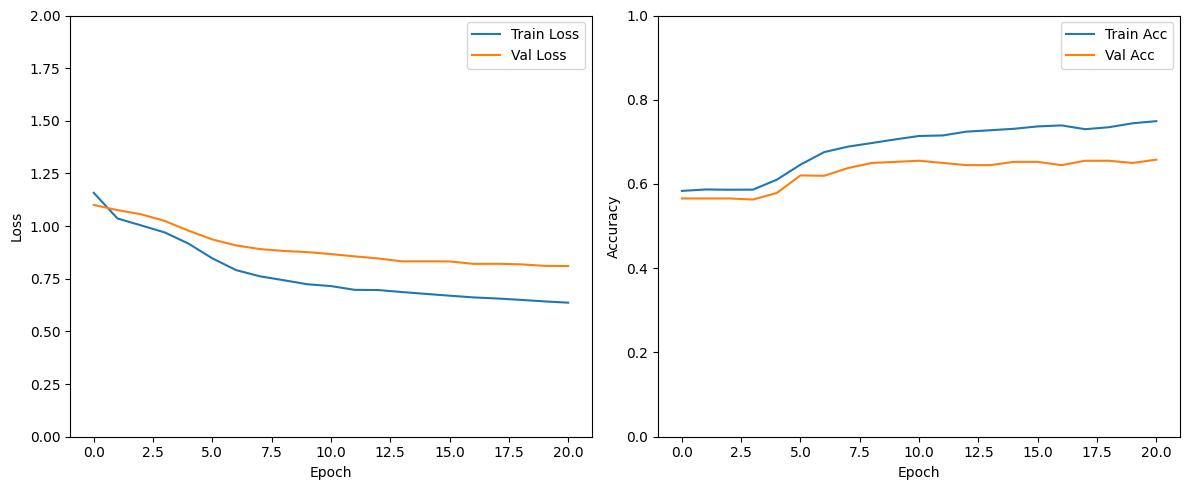

Training complete!


In [ ]:
hidden_dim = 256
num_heads = 4
max_len = 128
n_layers = 2

print("Initializing model...")
model = ImprovedABSAModel(
        bert_model,
        hidden_dim,
        output_dim,
        num_heads=num_heads,
        max_len=max_len,
        n_layers=n_layers,
    )
model = model.to(device)

# Train and evaluate model
print("Starting training...")
train_losses, train_accs, val_losses, val_accs = train_model(
        model,
        train_dataloader,
        val_dataloader,
        device, lr_given = 1e-5, n_epochs=21
    )

# Plot training and validation metrics
plot(train_losses, train_accs, val_losses, val_accs)

print("Training complete!")


### Architecture 2

Initializing model...
Starting training...
Epoch 1/10


100%|██████████| 93/93 [00:21<00:00,  4.23it/s]


Train Loss: 1.050 | Train Acc: 56.40417%
Val Loss: 1.028 | Val Acc: 56.56524%
Best model saved!

Epoch 2/10


100%|██████████| 93/93 [00:22<00:00,  4.15it/s]


Train Loss: 0.874 | Train Acc: 62.23316%
Val Loss: 0.935 | Val Acc: 61.95175%
Best model saved!

Epoch 3/10


100%|██████████| 93/93 [00:22<00:00,  4.08it/s]


Train Loss: 0.753 | Train Acc: 69.74818%
Val Loss: 0.872 | Val Acc: 65.51535%
Best model saved!

Epoch 4/10


100%|██████████| 93/93 [00:21<00:00,  4.25it/s]


Train Loss: 0.702 | Train Acc: 73.17165%
Val Loss: 0.857 | Val Acc: 65.77577%
Best model saved!

Epoch 5/10


100%|██████████| 93/93 [00:22<00:00,  4.21it/s]


Train Loss: 0.685 | Train Acc: 72.81388%
Val Loss: 0.850 | Val Acc: 64.21327%
Best model saved!

Epoch 6/10


100%|██████████| 93/93 [00:22<00:00,  4.07it/s]


Train Loss: 0.653 | Train Acc: 75.05337%
Val Loss: 0.827 | Val Acc: 66.55702%
Best model saved!

Epoch 7/10


100%|██████████| 93/93 [00:22<00:00,  4.18it/s]


Train Loss: 0.629 | Train Acc: 75.94877%
Val Loss: 0.829 | Val Acc: 67.59868%

Epoch 8/10


100%|██████████| 93/93 [00:21<00:00,  4.24it/s]


Train Loss: 0.617 | Train Acc: 76.01992%
Val Loss: 0.810 | Val Acc: 67.07785%
Best model saved!

Epoch 9/10


100%|██████████| 93/93 [00:22<00:00,  4.20it/s]


Train Loss: 0.587 | Train Acc: 76.53977%
Val Loss: 0.802 | Val Acc: 67.85910%
Best model saved!

Epoch 10/10


100%|██████████| 93/93 [00:22<00:00,  4.05it/s]


Train Loss: 0.577 | Train Acc: 78.07361%
Val Loss: 0.822 | Val Acc: 66.03618%



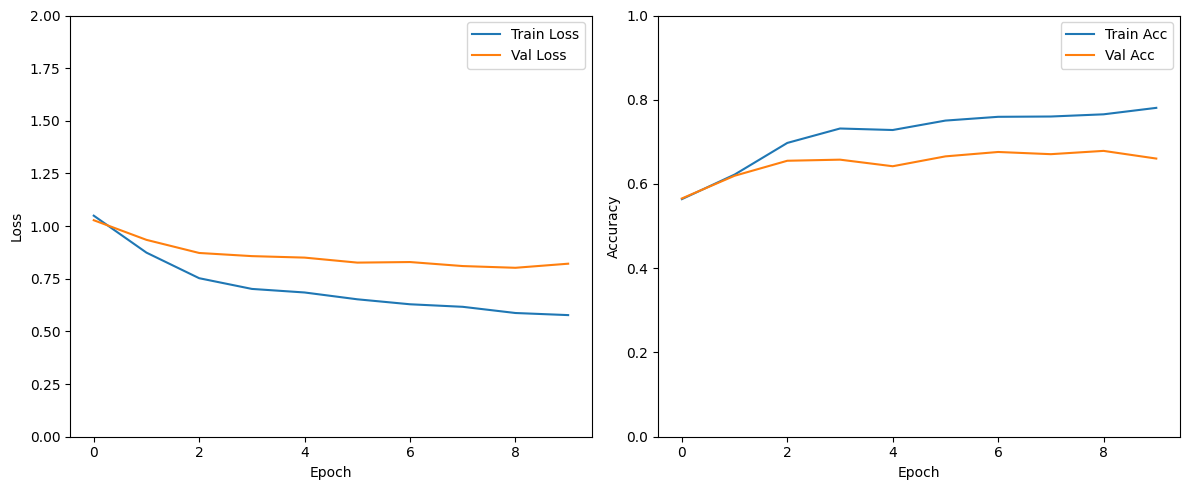

Training complete!


In [ ]:
# 5e-5 10

# Model hyperparameters
max_seq_length = 128
hidden_dim = 256
gcn_layers = 2


# Initialize model
print("Initializing model...")
model = GraphBasedSentimentModel(
        bert_model=bert_model,
        hidden_dim=hidden_dim,
        gcn_layers=gcn_layers,
        output_dim=output_dim)

model.initialize_graph_builder(max_seq_length=max_seq_length)

# Move model to device
model = model.to(device)

# Train the model
print("Starting training...")
train_losses, train_accs, val_losses, val_accs = train_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device, lr_given = 5e-5, n_epochs=10
    )

# Plot training results
plot(train_losses, train_accs, val_losses, val_accs)

print("Training complete!")

### Architecture 3

Initializing model...
Starting training...
Epoch 1/10


100%|██████████| 93/93 [01:09<00:00,  1.34it/s]


Train Loss: 1.085 | Train Acc: 57.25213%
Val Loss: 1.000 | Val Acc: 56.82566%
Best model saved!

Epoch 2/10


100%|██████████| 93/93 [01:09<00:00,  1.33it/s]


Train Loss: 0.784 | Train Acc: 69.33705%
Val Loss: 0.809 | Val Acc: 69.07895%
Best model saved!

Epoch 3/10


100%|██████████| 93/93 [01:10<00:00,  1.32it/s]


Train Loss: 0.633 | Train Acc: 76.21758%
Val Loss: 0.756 | Val Acc: 71.08004%
Best model saved!

Epoch 4/10


100%|██████████| 93/93 [01:09<00:00,  1.33it/s]


Train Loss: 0.546 | Train Acc: 79.27933%
Val Loss: 0.754 | Val Acc: 70.03838%
Best model saved!

Epoch 5/10


100%|██████████| 93/93 [01:12<00:00,  1.28it/s]


Train Loss: 0.476 | Train Acc: 82.50909%
Val Loss: 0.758 | Val Acc: 70.12061%

Epoch 6/10


100%|██████████| 93/93 [01:12<00:00,  1.28it/s]


Train Loss: 0.420 | Train Acc: 84.29791%
Val Loss: 0.717 | Val Acc: 72.98520%
Best model saved!

Epoch 7/10


100%|██████████| 93/93 [01:12<00:00,  1.28it/s]


Train Loss: 0.365 | Train Acc: 87.04538%
Val Loss: 0.749 | Val Acc: 72.80702%

Epoch 8/10


100%|██████████| 93/93 [01:12<00:00,  1.28it/s]


Train Loss: 0.317 | Train Acc: 88.81839%
Val Loss: 0.778 | Val Acc: 72.02577%

Epoch 9/10


100%|██████████| 93/93 [01:12<00:00,  1.28it/s]


Train Loss: 0.277 | Train Acc: 90.26724%
Val Loss: 0.747 | Val Acc: 74.12281%

Epoch 10/10


100%|██████████| 93/93 [01:10<00:00,  1.32it/s]


Train Loss: 0.245 | Train Acc: 91.87619%
Val Loss: 0.755 | Val Acc: 74.46546%



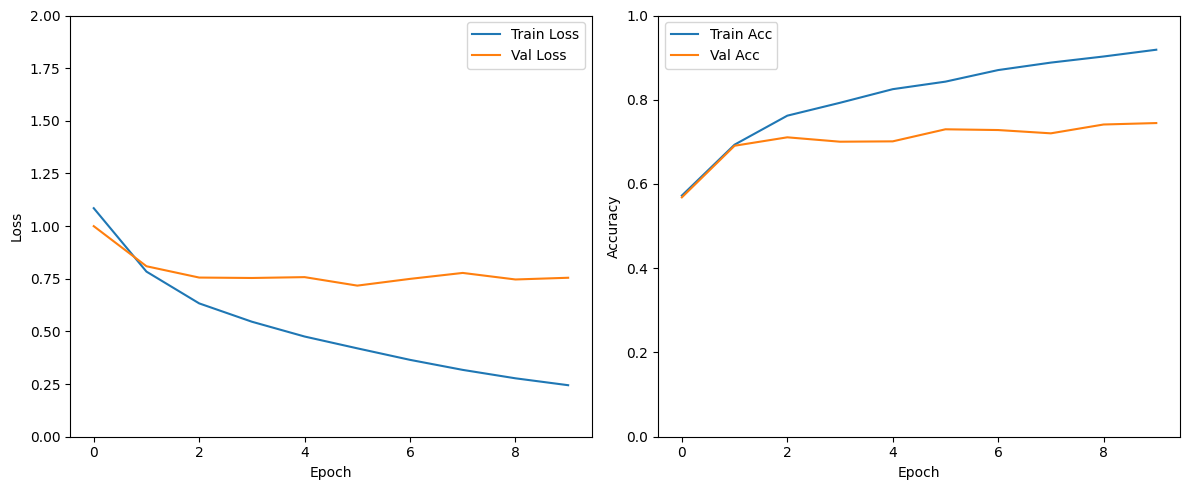

Training complete!


In [ ]:
# Model hyperparameters
max_seq_length = 128
hidden_dim = 256
gcn_layers = 2

# Initialize model
print("Initializing model...")
model = TD_LSTM_GCN(
    hidden_dim=hidden_dim,
    num_gcn_layers=gcn_layers,
    output_dim=output_dim)

model = model.to(device)

# Train the model
print("Starting training...")
train_losses, train_accs, val_losses, val_accs = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device, lr_given = 4e-6, n_epochs=10)


# Plot training results
plot(train_losses, train_accs, val_losses, val_accs)

print("Training complete!")


## 2.6 Additional Task

In [ ]:
class BERTForABSA(nn.Module):
    def __init__(self, pretrained_model="bert-base-uncased", output_dim=4):
        super(BERTForABSA, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(0.1)
        # Double the hidden size as we'll be combining aspect and context representations
        self.classifier = nn.Linear(self.bert.config.hidden_size * 2, output_dim)

    def forward(self, input_ids, attention_mask, token_type_ids=None, aspect_mask=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        sequence_output = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Get weighted aspect representation using the aspect mask
        aspect_mask = aspect_mask.unsqueeze(-1)  # [batch_size, seq_len, 1]
        aspect_sum = torch.sum(sequence_output * aspect_mask, dim=1)  # [batch_size, hidden_size]
        aspect_mask_sum = torch.sum(aspect_mask, dim=1) + 1e-10  # Add small epsilon to avoid division by zero
        aspect_representation = aspect_sum / aspect_mask_sum  # [batch_size, hidden_size]

        # Get sentence representation from [CLS] token
        sentence_representation = sequence_output[:, 0, :]  # [batch_size, hidden_size]

        # Concatenate aspect and sentence representations
        combined_representation = torch.cat([sentence_representation, aspect_representation], dim=1)
        combined_representation = self.dropout(combined_representation)

        # Pass through classifier
        logits = self.classifier(combined_representation)
        return logits


class BARTForABSA(nn.Module):
    def __init__(self, pretrained_model="facebook/bart-base", output_dim=4):
        super(BARTForABSA, self).__init__()
        self.bart = BartModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(0.1)
        # Double the hidden size as we'll be combining aspect and context representations
        self.classifier = nn.Linear(self.bart.config.d_model * 2, output_dim)

    def forward(self, input_ids, attention_mask, token_type_ids=None, aspect_mask=None):
        # BART doesn't use token_type_ids, so we ignore it
        outputs = self.bart(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        sequence_output = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Get weighted aspect representation using the aspect mask
        aspect_mask = aspect_mask.unsqueeze(-1)  # [batch_size, seq_len, 1]
        aspect_sum = torch.sum(sequence_output * aspect_mask, dim=1)  # [batch_size, hidden_size]
        aspect_mask_sum = torch.sum(aspect_mask, dim=1) + 1e-10  # Add small epsilon to avoid division by zero
        aspect_representation = aspect_sum / aspect_mask_sum  # [batch_size, hidden_size]

        # Get sentence representation from first token
        sentence_representation = sequence_output[:, 0, :]  # [batch_size, hidden_size]

        # Concatenate aspect and sentence representations
        combined_representation = torch.cat([sentence_representation, aspect_representation], dim=1)
        combined_representation = self.dropout(combined_representation)

        # Pass through classifier
        logits = self.classifier(combined_representation)
        return logits


class RoBERTaForABSA(nn.Module):
    def __init__(self, pretrained_model="roberta-base", output_dim=4):
        super(RoBERTaForABSA, self).__init__()
        self.roberta = RobertaModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(0.1)

        # Double the hidden size as we'll be combining aspect and context representations
        self.classifier = nn.Linear(self.roberta.config.hidden_size * 2, output_dim)

    def forward(self, input_ids, attention_mask, token_type_ids=None, aspect_mask=None):
        # RoBERTa doesn't use token_type_ids, so we ignore it
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        sequence_output = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Get weighted aspect representation using the aspect mask
        aspect_mask = aspect_mask.unsqueeze(-1)  # [batch_size, seq_len, 1]
        aspect_sum = torch.sum(sequence_output * aspect_mask, dim=1)  # [batch_size, hidden_size]
        aspect_mask_sum = torch.sum(aspect_mask, dim=1) + 1e-10  # Add small epsilon to avoid division by zero
        aspect_representation = aspect_sum / aspect_mask_sum  # [batch_size, hidden_size]

        # Get sentence representation from first token
        sentence_representation = sequence_output[:, 0, :]  # [batch_size, hidden_size]

        # Concatenate aspect and sentence representations
        combined_representation = torch.cat([sentence_representation, aspect_representation], dim=1)
        combined_representation = self.dropout(combined_representation)

        # Pass through classifier
        logits = self.classifier(combined_representation)
        return logits

In [ ]:
# Initialize tokenizers
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Create datasets
train_dataset_bert = ABSADataset(train_final_data, bert_tokenizer)
val_dataset_bert = ABSADataset(val_final_data, bert_tokenizer)

train_dataset_bart = ABSADataset(train_final_data, bart_tokenizer)
val_dataset_bart = ABSADataset(val_final_data, bart_tokenizer)

train_dataset_roberta = ABSADataset(train_final_data, roberta_tokenizer)
val_dataset_roberta = ABSADataset(val_final_data, roberta_tokenizer)

# Create dataloaders
train_dataloader_bert = DataLoader(train_dataset_bert, batch_size=32, shuffle=True)
val_dataloader_bert = DataLoader(val_dataset_bert, batch_size=32, shuffle=False)

train_dataloader_bart = DataLoader(train_dataset_bart, batch_size=32, shuffle=True)
val_dataloader_bart = DataLoader(val_dataset_bart, batch_size=32, shuffle=False)

train_dataloader_roberta = DataLoader(train_dataset_roberta, batch_size=32, shuffle=True)
val_dataloader_roberta = DataLoader(val_dataset_roberta, batch_size=32, shuffle=False)

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dim = 4

bert_model = BERTForABSA(output_dim=output_dim).to(device)
bart_model = BARTForABSA(output_dim=output_dim).to(device)
roberta_model = RoBERTaForABSA(output_dim=output_dim).to(device)




vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def train_model_finetune(model, train_dataloader, val_dataloader, device, lr_given, n_epochs):
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr_given)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    # n_epochs = 21
    best_val_loss = float('inf')

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}/{n_epochs}')

        # Train and evaluate
        train_loss, train_acc = train_model_batch(model, train_dataloader, optimizer, criterion, device)
        val_loss, val_acc = evaluate_model(model, val_dataloader, criterion, device)

        # Save metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.5f}%')
        print(f'Val Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.5f}%')

        # # Save best model
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     torch.save(model.state_dict(), 'best-absa-model.pt')
        #     print('Best model saved!')

        print()
    return train_losses, train_accs, val_losses, val_accs




### BERT

Fine-tuning BERT...
Epoch 1/10


100%|██████████| 93/93 [00:59<00:00,  1.55it/s]


Train Loss: 0.927 | Train Acc: 61.57495%
Val Loss: 0.829 | Val Acc: 67.85910%

Epoch 2/10


100%|██████████| 93/93 [00:59<00:00,  1.57it/s]


Train Loss: 0.627 | Train Acc: 76.25119%
Val Loss: 0.736 | Val Acc: 69.68202%

Epoch 3/10


100%|██████████| 93/93 [00:59<00:00,  1.57it/s]


Train Loss: 0.493 | Train Acc: 81.96750%
Val Loss: 0.677 | Val Acc: 72.82072%

Epoch 4/10


100%|██████████| 93/93 [00:59<00:00,  1.57it/s]


Train Loss: 0.392 | Train Acc: 85.76455%
Val Loss: 0.643 | Val Acc: 72.38213%

Epoch 5/10


100%|██████████| 93/93 [00:59<00:00,  1.57it/s]


Train Loss: 0.315 | Train Acc: 88.51202%
Val Loss: 0.669 | Val Acc: 73.94463%

Epoch 6/10


100%|██████████| 93/93 [00:59<00:00,  1.57it/s]


Train Loss: 0.238 | Train Acc: 91.93944%
Val Loss: 0.667 | Val Acc: 74.98629%

Epoch 7/10


100%|██████████| 93/93 [00:59<00:00,  1.57it/s]


Train Loss: 0.193 | Train Acc: 93.65315%
Val Loss: 0.697 | Val Acc: 76.98739%

Epoch 8/10


100%|██████████| 93/93 [00:59<00:00,  1.57it/s]


Train Loss: 0.152 | Train Acc: 95.26605%
Val Loss: 0.688 | Val Acc: 76.72697%

Epoch 9/10


100%|██████████| 93/93 [00:59<00:00,  1.57it/s]


Train Loss: 0.111 | Train Acc: 96.64769%
Val Loss: 0.729 | Val Acc: 74.98629%

Epoch 10/10


100%|██████████| 93/93 [00:59<00:00,  1.57it/s]


Train Loss: 0.090 | Train Acc: 97.58065%
Val Loss: 0.768 | Val Acc: 74.64364%



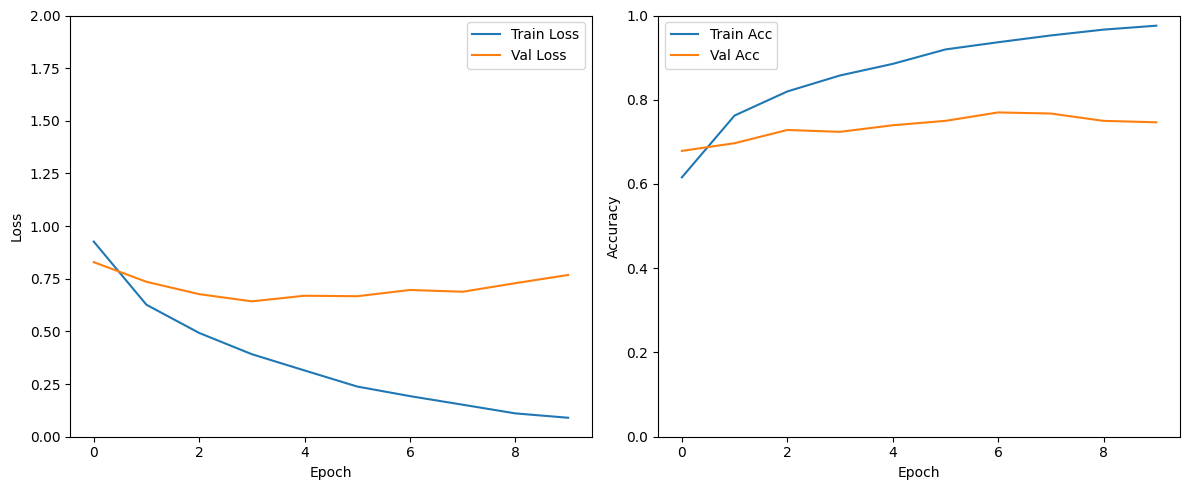

In [ ]:
# Fine-tune and evaluate BERT
print("Fine-tuning BERT...")
bert_train_losses, bert_train_accs, bert_val_losses, bert_val_accs = train_model_finetune(
    model=bert_model,
    train_dataloader=train_dataloader_bert,
    val_dataloader=val_dataloader_bert,
    device=device,
    lr_given=1e-5,
    n_epochs=10
)
plot(bert_train_losses, bert_train_accs, bert_val_losses, bert_val_accs)


### BART

Fine-tuning BART...
Epoch 1/10


100%|██████████| 93/93 [01:11<00:00,  1.31it/s]


Train Loss: 1.116 | Train Acc: 57.58025%
Val Loss: 0.923 | Val Acc: 64.21327%

Epoch 2/10


100%|██████████| 93/93 [01:10<00:00,  1.31it/s]


Train Loss: 0.777 | Train Acc: 69.57622%
Val Loss: 0.823 | Val Acc: 62.84265%

Epoch 3/10


100%|██████████| 93/93 [01:11<00:00,  1.31it/s]


Train Loss: 0.655 | Train Acc: 75.95272%
Val Loss: 0.875 | Val Acc: 66.73520%

Epoch 4/10


100%|██████████| 93/93 [01:10<00:00,  1.31it/s]


Train Loss: 0.513 | Train Acc: 80.48110%
Val Loss: 0.960 | Val Acc: 67.17379%

Epoch 5/10


100%|██████████| 93/93 [01:11<00:00,  1.31it/s]


Train Loss: 0.443 | Train Acc: 84.31175%
Val Loss: 1.134 | Val Acc: 60.73191%

Epoch 6/10


100%|██████████| 93/93 [01:11<00:00,  1.31it/s]


Train Loss: 0.381 | Train Acc: 86.10057%
Val Loss: 1.101 | Val Acc: 64.65186%

Epoch 7/10


100%|██████████| 93/93 [01:10<00:00,  1.31it/s]


Train Loss: 0.317 | Train Acc: 89.05756%
Val Loss: 0.980 | Val Acc: 64.99452%

Epoch 8/10


100%|██████████| 93/93 [01:10<00:00,  1.31it/s]


Train Loss: 0.268 | Train Acc: 90.83847%
Val Loss: 1.048 | Val Acc: 63.59649%

Epoch 9/10


100%|██████████| 93/93 [01:10<00:00,  1.31it/s]


Train Loss: 0.297 | Train Acc: 89.29277%
Val Loss: 1.141 | Val Acc: 62.12993%

Epoch 10/10


100%|██████████| 93/93 [01:10<00:00,  1.31it/s]


Train Loss: 0.266 | Train Acc: 90.25538%
Val Loss: 1.218 | Val Acc: 65.95395%



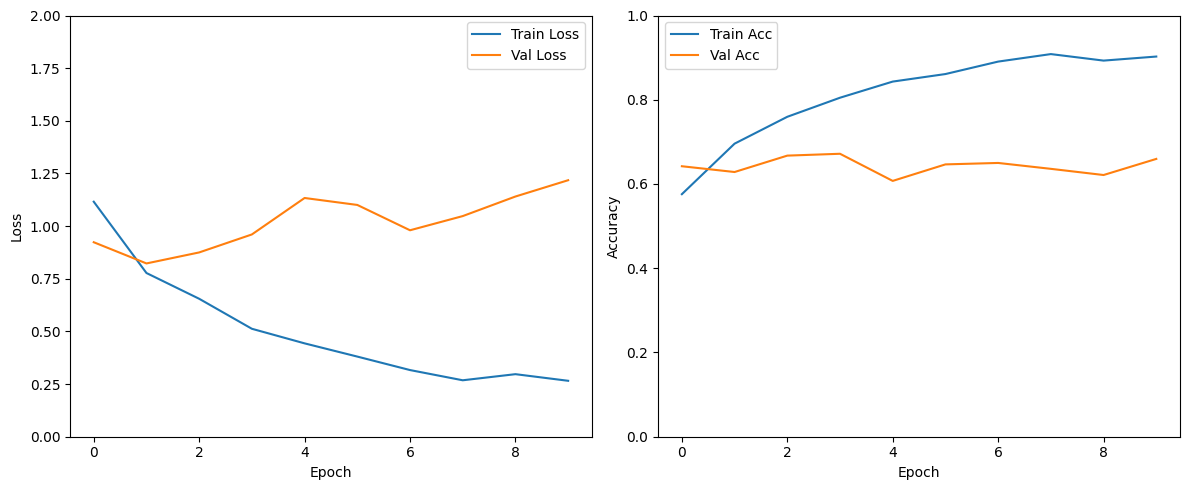

In [ ]:
# Fine-tune and evaluate BART
print("Fine-tuning BART...")
bart_train_losses, bart_train_accs, bart_val_losses, bart_val_accs = train_model_finetune(
    model=bart_model,
    train_dataloader=train_dataloader_bart,
    val_dataloader=val_dataloader_bart,
    device=device,
    lr_given=2e-4,
    n_epochs=10
)
plot(bart_train_losses, bart_train_accs, bart_val_losses, bart_val_accs)



### RoBERTa

Fine-tuning RoBERTa...
Epoch 1/10


100%|██████████| 93/93 [00:58<00:00,  1.59it/s]


Train Loss: 4.237 | Train Acc: 42.15884%
Val Loss: 1.413 | Val Acc: 56.56524%

Epoch 2/10


100%|██████████| 93/93 [00:57<00:00,  1.61it/s]


Train Loss: 1.231 | Train Acc: 56.90425%
Val Loss: 1.408 | Val Acc: 56.56524%

Epoch 3/10


100%|██████████| 93/93 [00:58<00:00,  1.60it/s]


Train Loss: 1.100 | Train Acc: 57.66327%
Val Loss: 1.131 | Val Acc: 56.56524%

Epoch 4/10


100%|██████████| 93/93 [00:58<00:00,  1.60it/s]


Train Loss: 1.112 | Train Acc: 58.65552%
Val Loss: 1.133 | Val Acc: 56.56524%

Epoch 5/10


100%|██████████| 93/93 [00:57<00:00,  1.61it/s]


Train Loss: 1.080 | Train Acc: 58.13370%
Val Loss: 1.132 | Val Acc: 56.56524%

Epoch 6/10


100%|██████████| 93/93 [00:58<00:00,  1.60it/s]


Train Loss: 1.090 | Train Acc: 58.44798%
Val Loss: 1.143 | Val Acc: 56.56524%

Epoch 7/10


100%|██████████| 93/93 [00:57<00:00,  1.61it/s]


Train Loss: 1.087 | Train Acc: 57.30155%
Val Loss: 1.104 | Val Acc: 56.56524%

Epoch 8/10


100%|██████████| 93/93 [00:58<00:00,  1.60it/s]


Train Loss: 1.085 | Train Acc: 58.31357%
Val Loss: 1.261 | Val Acc: 56.56524%

Epoch 9/10


100%|██████████| 93/93 [00:58<00:00,  1.60it/s]


Train Loss: 1.106 | Train Acc: 55.56807%
Val Loss: 1.162 | Val Acc: 56.56524%

Epoch 10/10


100%|██████████| 93/93 [00:58<00:00,  1.60it/s]


Train Loss: 1.072 | Train Acc: 57.45375%
Val Loss: 1.248 | Val Acc: 56.56524%



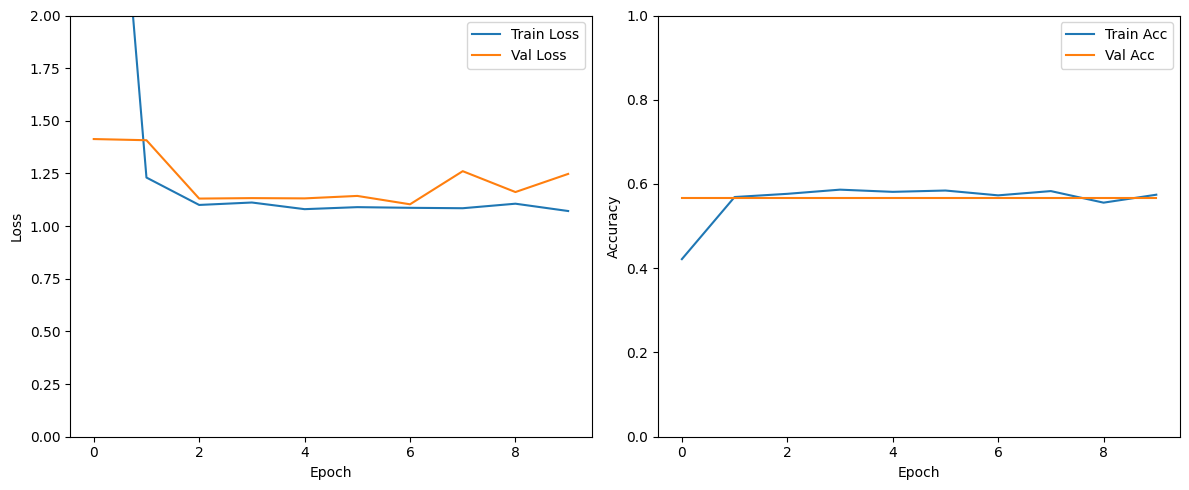

In [ ]:
# Fine-tune and evaluate RoBERTa
print("Fine-tuning RoBERTa...")
roberta_train_losses, roberta_train_accs, roberta_val_losses, roberta_val_accs = train_model_finetune(
    model=roberta_model,
    train_dataloader=train_dataloader_roberta,
    val_dataloader=val_dataloader_roberta,
    device=device,
    lr_given=5e-2,
    n_epochs=10
)
plot(roberta_train_losses, roberta_train_accs, roberta_val_losses, roberta_val_accs)

## Task 2.5

In [19]:
import json
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score

def test_inference(test_file_path, model_path='best-absa-model.pt'):
    """
    Load the trained model, process test.json, and return the accuracy score.

    Args:
        test_file_path (str): Path to the test.json file
        model_path (str): Path to the saved model file

    Returns:
        float: Accuracy score
    """
    # Load test data
    with open(test_file_path, "r", encoding="utf-8") as file:
        test_data = json.load(file)

    # Preprocess test data - assuming you have the preprocess_data function
    test_final = preprocess_data(test_data)

    # Initialize BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Create test dataset
    test_dataset = ABSADataset(test_final, tokenizer)

    # Create dataloader
    test_dataloader = DataLoader(test_dataset, batch_size=32)

    # Load the trained model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize your model architecture - you'll need to define this based on your specific model
    # For example:
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    model = TD_LSTM_GCN(
    hidden_dim=256,
    num_gcn_layers=2,
    output_dim=4)

    # Load state dictionary
    model_state = torch.load(model_path, map_location=device)

    model.load_state_dict(model_state)

    model.to(device)
    model.eval()

    # Perform inference
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_dataloader:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            aspect_mask = batch['aspect_mask'].to(device)
            polarity = batch['polarity'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask, token_type_ids, aspect_mask)
            _, preds = torch.max(outputs, 1)

            # Collect predictions and labels
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(polarity.cpu().numpy())
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

test_inference("val.json")

Test Accuracy: 72.78%
